In [1]:
!pip install --upgrade --force-reinstall numpy==1.26.4 scipy==1.13.1 gensim==4.3.3

  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scipy-1.13.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached gensim-4.3.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
Using cached scipy-1.13.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.2 MB)
Using cached gensim-4.3.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 899.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.3
    Uninstalling wrapt-1.17.3:
      Successfully uninstalled wrapt-1.17.3
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling 

In [8]:
import pandas as pd
import numpy as np
import re
from collections import defaultdict

from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, fcluster

import warnings
warnings.filterwarnings('ignore')

In [9]:
#Pre-processing

In [10]:
def load_multiple_books(file_paths):
    all_data = []
    for file_path in file_paths:
        try:
            df = pd.read_csv(file_path, sep=';', encoding='utf-8')
            df['Book'] = file_path.split('/')[-1].replace('.csv', '')
            all_data.append(df)
            print(f"Loaded {len(df)} dialogues from {file_path}")
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    return pd.concat(all_data, ignore_index=True)

def load_and_preprocess_data(file_paths):
    df = load_multiple_books(file_paths)
    df['Character'] = df['Character'].str.strip().str.upper()

    character_mapping = {
        'HARRY POTTER': 'HARRY', 'HERMIONE GRANGER': 'HERMIONE', 'RON WEASLEY': 'RON',
        'PROFESSOR MCGONAGALL': 'MCGONAGALL', 'PROFESSOR SNAPE': 'SNAPE',
        'ALBUS DUMBLEDORE': 'DUMBLEDORE', 'LORD VOLDEMORT': 'VOLDEMORT',
        'TOM MARVOLO RIDDLE': 'TOM RIDDLE', 'GILDEROY': 'GILDEROY LOCKHART',
        'LOCKHART': 'GILDEROY LOCKHART', 'MOANING MYRTLE': 'MYRTLE',
        'SIR NICHOLAS DE MIMSY-PORPINGTON': 'SIR NICHOLAS',
        'NEARLY HEADLESS NICK': 'SIR NICHOLAS'
    }
    df['Character'] = df['Character'].replace(character_mapping)

    df['Sentence'] = df['Sentence'].str.replace(r'[^a-zA-Z\s\.,!?]', '', regex=True)
    df['Sentence'] = df['Sentence'].str.lower()
    df = df[df['Sentence'].str.len() > 10]
    return df


In [11]:
#Word2Vec Training

In [12]:
def preprocess_text(text):
    text = re.sub(r'[^\w\s\.!?,]', '', text.lower())
    tokens = text.split()
    return [token for token in tokens if len(token) > 2]

def train_word2vec_model(character_dialogues):
    sentences = []
    for dialogues in character_dialogues.values():
        for dialogue in dialogues:
            tokens = preprocess_text(dialogue)
            if len(tokens) > 2:
                sentences.append(tokens)

    model = Word2Vec(
        sentences=sentences,
        vector_size=300,
        window=8,
        min_count=3,
        workers=6,
        sg=1,
        epochs=20,
        negative=15,
        sample=1e-5
    )
    return model


In [13]:
# Creating Character Embeddings

In [14]:
def get_character_embeddings(model, character_dialogues):
    character_embeddings = {}
    for char, dialogues in character_dialogues.items():
        all_vectors = []
        for dialogue in dialogues:
            tokens = preprocess_text(dialogue)
            word_vectors, weights = [], []
            for word in tokens:
                if word in model.wv:
                    word_vectors.append(model.wv[word])
                    word_freq = model.wv.get_vecattr(word, 'count')
                    weights.append(1.0 / (1.0 + np.log(1.0 + word_freq)))
            if word_vectors:
                weights = np.array(weights) / np.sum(weights)
                dialogue_vector = np.average(word_vectors, axis=0, weights=weights)
                all_vectors.append(dialogue_vector)
        character_embeddings[char] = np.median(all_vectors, axis=0) if all_vectors else np.zeros(model.vector_size)
    return character_embeddings


In [15]:
# Similarity Calculation and Visualization

In [16]:
def calculate_similarity_matrix(character_embeddings):
    characters = list(character_embeddings.keys())
    vectors = np.array([character_embeddings[char] for char in characters])
    similarity_matrix = cosine_similarity(vectors)
    np.fill_diagonal(similarity_matrix, 0.999)
    return pd.DataFrame(similarity_matrix, index=characters, columns=characters)

def visualize_similarity(similarity_df):
    plt.figure(figsize=(16, 14))
    top_chars = similarity_df.sum(axis=1).nlargest(20).index
    top_similarity = similarity_df.loc[top_chars, top_chars]
    mask = np.triu(np.ones_like(top_similarity, dtype=bool))
    sns.heatmap(top_similarity, annot=True, cmap='RdBu_r', center=0, square=True,
                fmt='.3f', cbar_kws={'label': 'Cosine Similarity'}, mask=mask)
    plt.title('Character Similarity Matrix (Top 20 Characters)', fontsize=16, pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


In [17]:
def get_most_similar_characters(similarity_df, top_n=5, min_similarity=0.3):
    results = {}
    for character in similarity_df.index:
        char_similarities = similarity_df[character].copy()
        char_similarities[character] = 0
        char_similarities = char_similarities[char_similarities >= min_similarity]
        top_similar = char_similarities.nlargest(top_n)
        results[character] = [(similar_char, round(score, 4)) for similar_char, score in top_similar.items()]
    return results


In [19]:
# Main analysis

In [20]:
def analyze_character_similarity(file_paths):
    print("Loading and preprocessing data...")
    df = load_and_preprocess_data(file_paths)

    character_dialogues = defaultdict(list)
    for _, row in df.iterrows():
        character_dialogues[row['Character']].append(row['Sentence'])

    print(f"Found {len(character_dialogues)} unique characters")

    min_dialogues = 10
    filtered_characters = {char: d for char, d in character_dialogues.items() if len(d) >= min_dialogues}

    print(f"Characters with {min_dialogues}+ lines: {len(filtered_characters)}")

    print("Training Word2Vec...")
    model = train_word2vec_model(filtered_characters)

    print("Calculating embeddings...")
    character_embeddings = get_character_embeddings(model, filtered_characters)

    print("Calculating similarity matrix...")
    similarity_df = calculate_similarity_matrix(character_embeddings)

    similar_characters = get_most_similar_characters(similarity_df, top_n=5, min_similarity=0.4)

    return similarity_df, similar_characters, model, character_embeddings, df


In [21]:
# Clustering

In [22]:
def enhanced_analysis(similarity_df, similar_characters, df):
    print("\nENHANCED CHARACTER SIMILARITY ANALYSIS")

    top_chars = similarity_df.sum(axis=1).nlargest(15).index
    formatted_similarity = similarity_df.loc[top_chars, top_chars].applymap(lambda x: f"{x:.3f}")
    print(formatted_similarity)

    all_pairs = []
    for char, sims in similar_characters.items():
        for similar_char, score in sims:
            if char < similar_char and score > 0.6:
                all_pairs.append((score, char, similar_char))
    all_pairs.sort(reverse=True, key=lambda x: x[0])

    print("\nTop 25 Similar Character Pairs:")
    for i, (score, char1, char2) in enumerate(all_pairs[:25], 1):
        print(f"{i:2d}. {char1:20} ↔ {char2:20} : {score:.4f}")

    distance_matrix = 1 - similarity_df.values
    Z = linkage(pdist(distance_matrix), 'average')
    clusters = fcluster(Z, t=0.7, criterion='distance')

    cluster_groups = defaultdict(list)
    for i, cluster_id in enumerate(clusters):
        cluster_groups[cluster_id].append(similarity_df.index[i])

    print("\nCharacter Clusters:")
    for cluster_id, chars in cluster_groups.items():
        if len(chars) > 1:
            avg_sim = similarity_df.loc[chars, chars].values.mean()
            print(f"Cluster {cluster_id}: {', '.join(sorted(chars))} | Avg similarity: {avg_sim:.3f}")
    return all_pairs


In [23]:
#PCA Visualization

In [24]:
def plot_character_embeddings(character_embeddings, similarity_df):
    characters = list(character_embeddings.keys())
    vectors = np.array([character_embeddings[char] for char in characters])
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(vectors)

    plt.figure(figsize=(14, 12))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7)

    for i, char in enumerate(characters):
        if similarity_df.mean(axis=1)[char] > similarity_df.values.mean():
            plt.annotate(char, (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                         xytext=(5, 5), textcoords='offset points', fontsize=9)

    plt.title('Character Embeddings (PCA Visualization)', fontsize=16)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


In [25]:
# Dialogue Pattern Analysis

In [26]:
def analyze_dialogue_patterns(df, similarity_df):
    print("\nDIALOGUE PATTERN ANALYSIS")
    print("-" * 30)

    char_stats = df['Character'].value_counts().head(10)
    print("\nTop 10 characters by dialogues:")
    for char, count in char_stats.items():
        print(f"  {char}: {count} dialogues")

    avg_similarities = similarity_df.mean(axis=1)
    print("\nMost distinctive characters (lowest similarity):")
    for char in avg_similarities.nsmallest(5).index:
        print(f"  {char}: {avg_similarities[char]:.4f}")

    print("\nMost central characters (highest similarity):")
    for char in avg_similarities.nlargest(5).index:
        print(f"  {char}: {avg_similarities[char]:.4f}")


Loading and preprocessing data...
Loaded 1587 dialogues from /content/Harry_Potter_1.csv
Loaded 1700 dialogues from /content/Harry_Potter_2.csv
Loaded 1638 dialogues from /content/Harry_Potter_3.csv
Found 78 unique characters
Characters with 10+ lines: 40
Training Word2Vec...
Calculating embeddings...
Calculating similarity matrix...

ENHANCED CHARACTER SIMILARITY ANALYSIS
                   HARRY HERMIONE DUMBLEDORE HAGRID    RON MCGONAGALL  SNAPE  \
HARRY              0.999    0.962      0.942  0.950  0.955      0.929  0.924   
HERMIONE           0.962    0.999      0.943  0.943  0.957      0.927  0.920   
DUMBLEDORE         0.942    0.943      0.999  0.932  0.923      0.932  0.928   
HAGRID             0.950    0.943      0.932  0.999  0.937      0.914  0.903   
RON                0.955    0.957      0.923  0.937  0.999      0.919  0.902   
MCGONAGALL         0.929    0.927      0.932  0.914  0.919      0.999  0.933   
SNAPE              0.924    0.920      0.928  0.903  0.902      

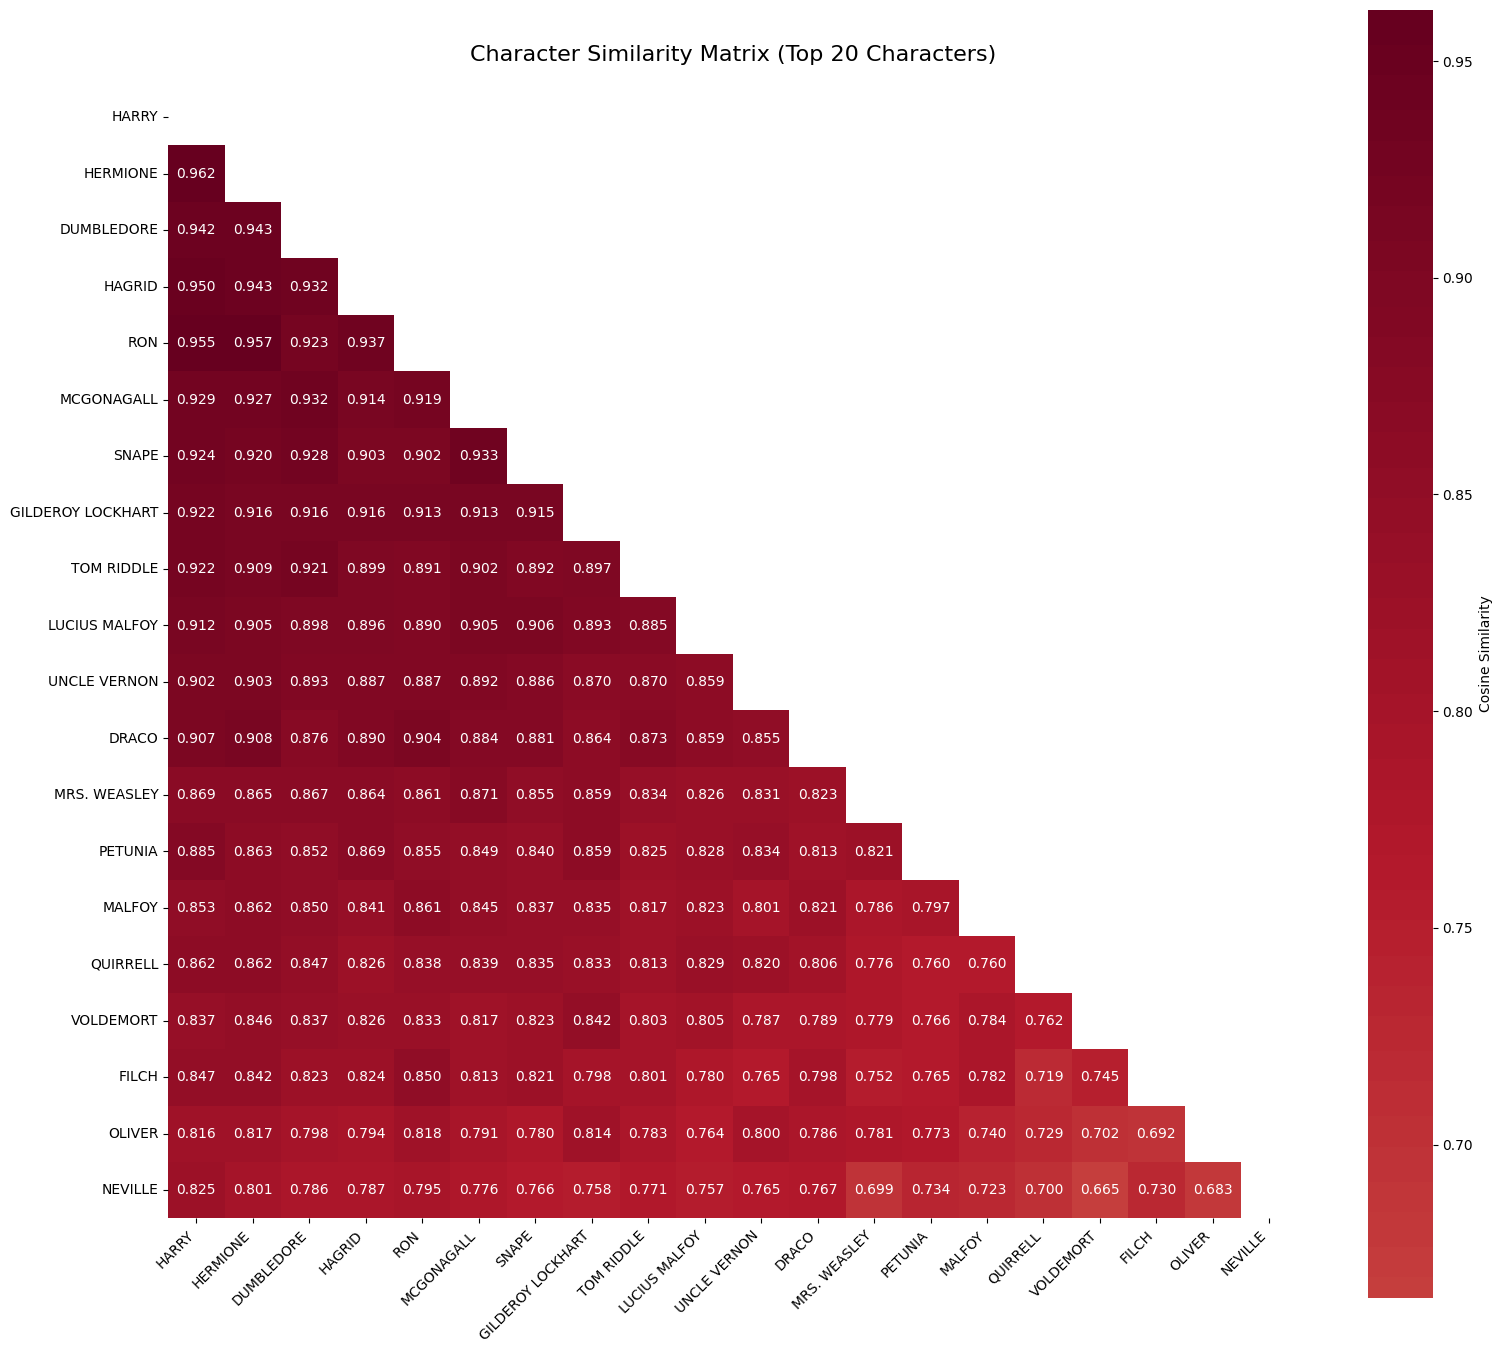

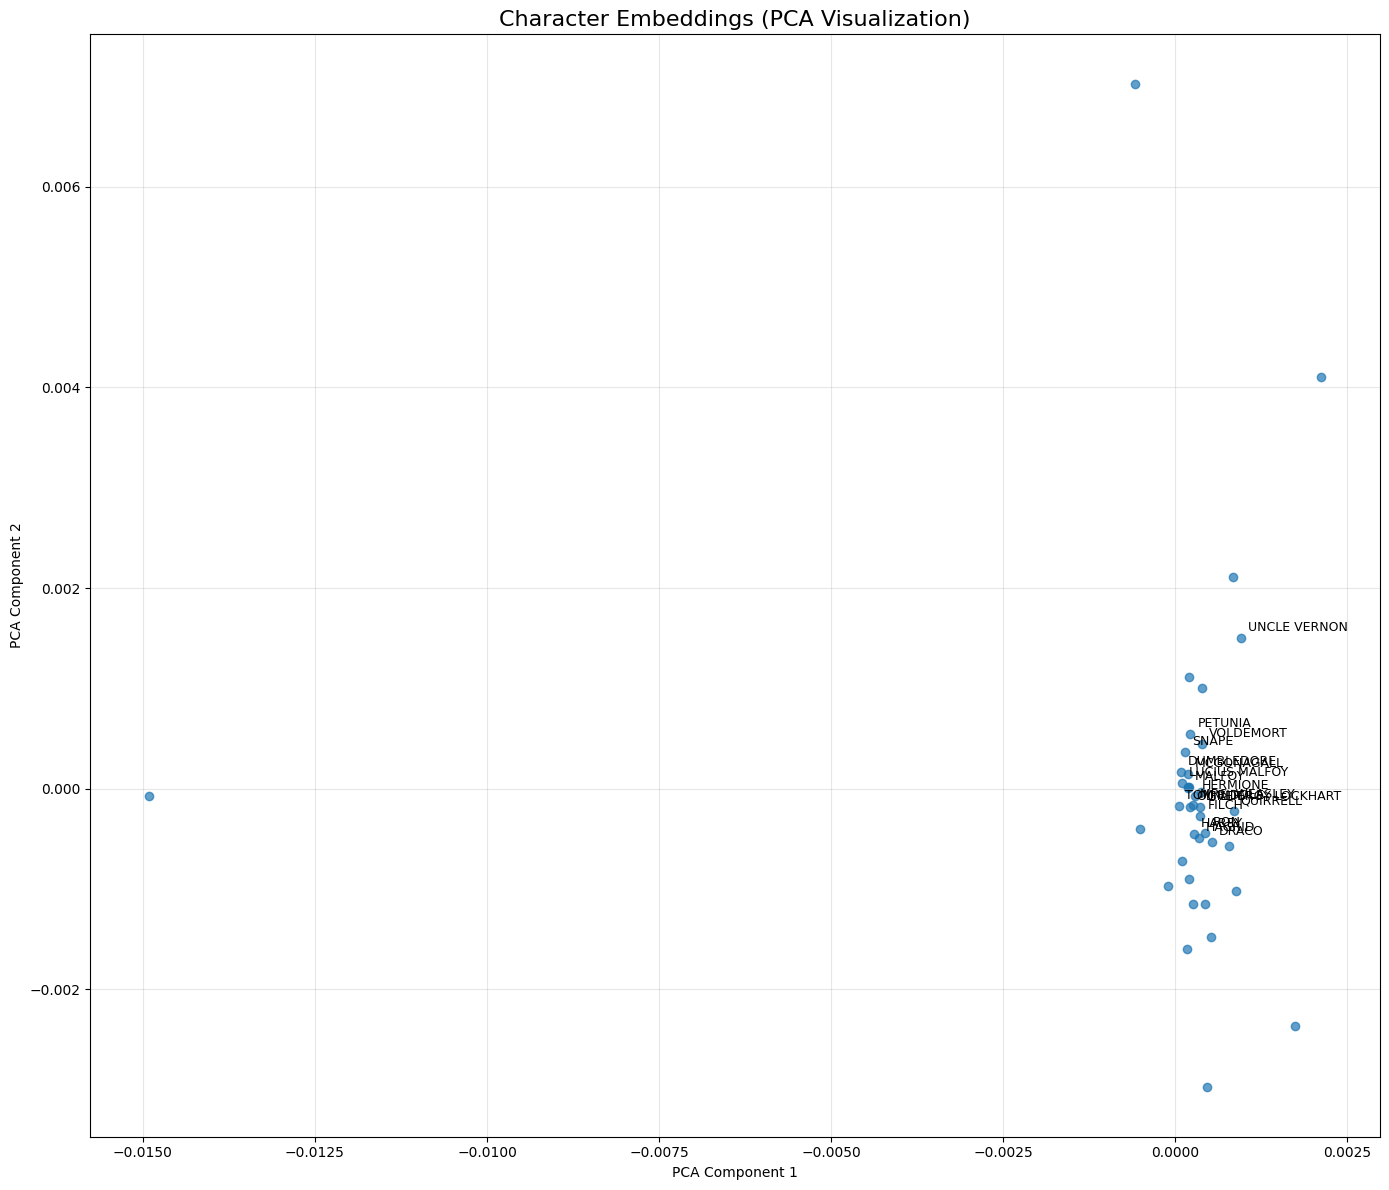


Results saved to 'character_similarity_matrix.csv'


In [27]:
file_paths = [
    "/content/Harry_Potter_1.csv",
    "/content/Harry_Potter_2.csv",
    "/content/Harry_Potter_3.csv"
]

similarity_df, similar_characters, model, embeddings, df = analyze_character_similarity(file_paths)

top_pairs = enhanced_analysis(similarity_df, similar_characters, df)

analyze_dialogue_patterns(df, similarity_df)

visualize_similarity(similarity_df)
plot_character_embeddings(embeddings, similarity_df)

similarity_df.to_csv('character_similarity_matrix.csv')
print("\nResults saved to 'character_similarity_matrix.csv'")


##Top Similarities That Make Perfect Sense:

Harry ↔ Hermione (0.96) - Best friends, similar heroic values.

Hermione ↔ Ron (0.96) - Best friends, later romantic relationship.

Harry ↔ Ron (0.96) - Best friends, similar age and experiences.

Hagrid ↔ Harry (0.95) - Close mentor relationship, both brave and loyal.

Dumbledore ↔ Hermione (0.94) - Both highly intelligent, wise, value knowledge.

##Other Plausible Relationships:
McGonagall ↔ Snape (0.93) - Both strict professors, Hogwarts staff.


Lucius Malfoy ↔ Snape (0.91) - Both Death Eaters, Slytherin connections.

##Good Cluster Grouping:
Cluster 1 contains all the main characters who interact frequently at Hogwarts.

Cluster 2 contains supporting characters with less dialogue.

Cluster 3-4 are small groups with specific relationships.

##Central vs Distinctive Characters:
Most Central: Harry, Hermione, Dumbledore, Hagrid, Ron.

Most Distinctive: Voice, Seamus, Fred, Dudley, Sir Nicholas.